In [1]:
import xarray as xr

In [2]:
ds = xr.open_zarr('../../runs/noaugment/preds.zarr')

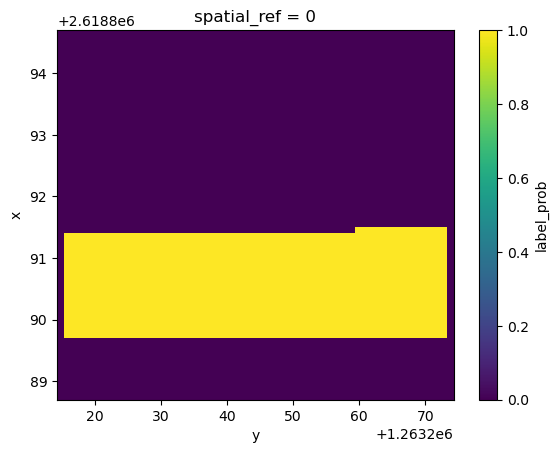

In [3]:
ds.label_prob.isel(x=slice(None, 60)).sum('cls').plot(vmin=0, vmax=1)

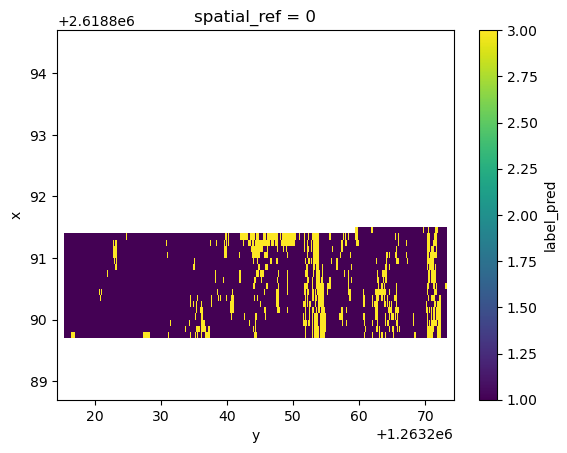

In [6]:
ds.label_pred.isel(x=slice(None, 60)).plot()

In [5]:
import numpy as np

In [6]:
np.argmax(ds.label_pred.values, axis=-1).astype('float16')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [17]:
ds['label_pred_max'] = xr.full_like(ds['label_pred'].isel(cls=0), fill_value=np.nan)
ds['label_pred_max'].values = np.argmax(ds.label_pred.values, axis=-1).astype('float16')
ds['label_pred_max'] = ds['label_pred_max'].where(ds['label_pred'].isel(cls=0).notnull())

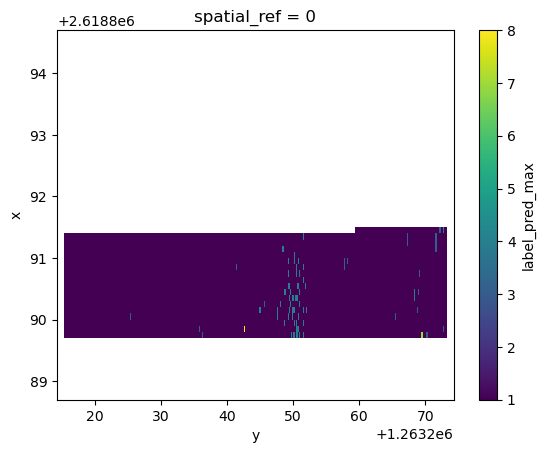

In [20]:
ds.label_pred_max.isel(x=slice(None, 60)).plot()

In [1]:
from src.dataloader import RSDataModule

In [2]:
datamodule = RSDataModule(
    ds_path='../../data/Sample_CombinedData_32signed/combined.zarr',
    train_area_ids=[1, 2],
    valid_area_ids=[3],
    test_area_ids=[4],
    cutout_size=21,
    batch_size=10,
)

In [3]:
pred_dl = datamodule.predict_dataloader()

In [4]:
pred_dl.dataset.ds

<xarray.Dataset> Size: 19MB
Dimensions:      (band: 4, x: 2947, y: 600)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
    spatial_ref  int64 8B 0
  * x            (x) float64 24kB 2.619e+06 2.619e+06 ... 2.619e+06 2.619e+06
  * y            (y) float64 5kB 1.263e+06 1.263e+06 ... 1.263e+06 1.263e+06
Data variables:
    label        (x, y) uint8 2MB 255 255 255 255 255 255 255 ... 3 3 3 3 3 3 3
    mask         (x, y) uint8 2MB dask.array<chunksize=(2947, 500), meta=np.ndarray>
    rs           (band, x, y) uint16 14MB dask.array<chunksize=(4, 500, 500), meta=np.ndarray>
    label_pred   (x, y) uint8 2MB 255 255 255 255 255 ... 255 255 255 255 255
Attributes:
    creator:  Julian Kraft

In [ ]:
next(iter(train_dl))

In [1]:
from src.augmentors import AugmentorChain

In [3]:
AugmentorChain.from_args('FlipAugmentor', PixelNoiseAugmentor={'scale': 1.0}, random_seed=1)

AugmentorChain(random_seed=1, augmentors=[PixelNoiseAugmentor(scale=1.0), FlipAugmentor()])

In [ ]:
from typing import Any, Sequence
import lightning.pytorch as pl
from lightning.pytorch.callbacks import BasePredictionWriter
import logging
from torch.utils.data import DataLoader
import xarray as xr
import numpy as np
import os
import warnings

from torch import Tensor
from typing import cast


class PredictionWriter(BasePredictionWriter):
    def __init__(self, output_dir: str):
        super().__init__(write_interval='batch')
        # self.output_dir = output_dir
        # os.makedirs(output_dir, exist_ok=True)

    def write_on_batch_end(
            self,
            trainer: pl.Trainer,
            pl_module: pl.LightningModule,
            prediction: tuple[Tensor, dict[str, int]],
            batch_indices: Sequence[int] | None,
            batch: Any,
            batch_idx: int,
            dataloader_idx: int) -> None:

        predicted_label, xy_i = prediction
        predict_dataloader = cast(DataLoader, trainer.predict_dataloaders)
        ds = cast(xr.Dataset, predict_dataloader.dataset.ds)  # type: ignore

        ds['label_pred']['x': xy_i['xi'], 'x': xy_i['y']] = predicted_label

    # @staticmethod
    # def make_predition_path(output_dir: str) -> str:
    #     return os.path.join(output_dir, 'preds.zarr')